# Imaging for volve data redatuming

In [2]:
# env: UD_RM
import warnings
import os
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp2d
from scipy.signal import convolve
from subroutine.imaging import MarchenkoImaging
from pylops.waveeqprocessing.kirchhoff import Kirchhoff

warnings.filterwarnings('ignore')
plt.close('all')

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

from pylops.utils.wavelets             import *

warnings.filterwarnings('ignore')
plt.close('all')

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

## Inputs

In [3]:
# Input parameters
inputfile = '/home/wangn0e/2022-2023/first_research/dataset/volve_imaging_full_fmax30_shifttry1.npz' 


tsoff = 0.02         # direct arrival time shift source side
troff = 0.02         # direct arrival time shift receiver side
nsmooth = 10         # time window smoothing
nfmax = 800          # max frequency for MDC (#samples)
niter = 10           # iterations
vel_s = 1500
convolvedata = True  # apply convolution to data
igaths = [41, 61,
          81, 101,
          121]        # indeces of angle gathers
nalpha = 61          # number of angles in Angle gathers

igaths = [1, 2, 3]        # indeces of angle gathers
nalpha = 2          # number of angles in Angle gathers

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = np.mean(np.abs(np.diff(r[0])))

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = np.mean(np.abs(np.diff(s[0])))

# vel = inputdata['vel']
z, x = inputdata['z'], inputdata['x']
nz, nx = z.shape[0], x.shape[0]
dz, dx = np.mean(np.diff(z)), np.mean(np.diff(x))

# Time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# Wavelet
wav, _, wav_c = ricker(t[0:51], 25)
wav_c = np.argmax(wav)

# Wavefield data 
Pu = inputdata['Pu'] #should be (r,s,t)
Pd = inputdata['Pd']

vel = inputdata['vel']

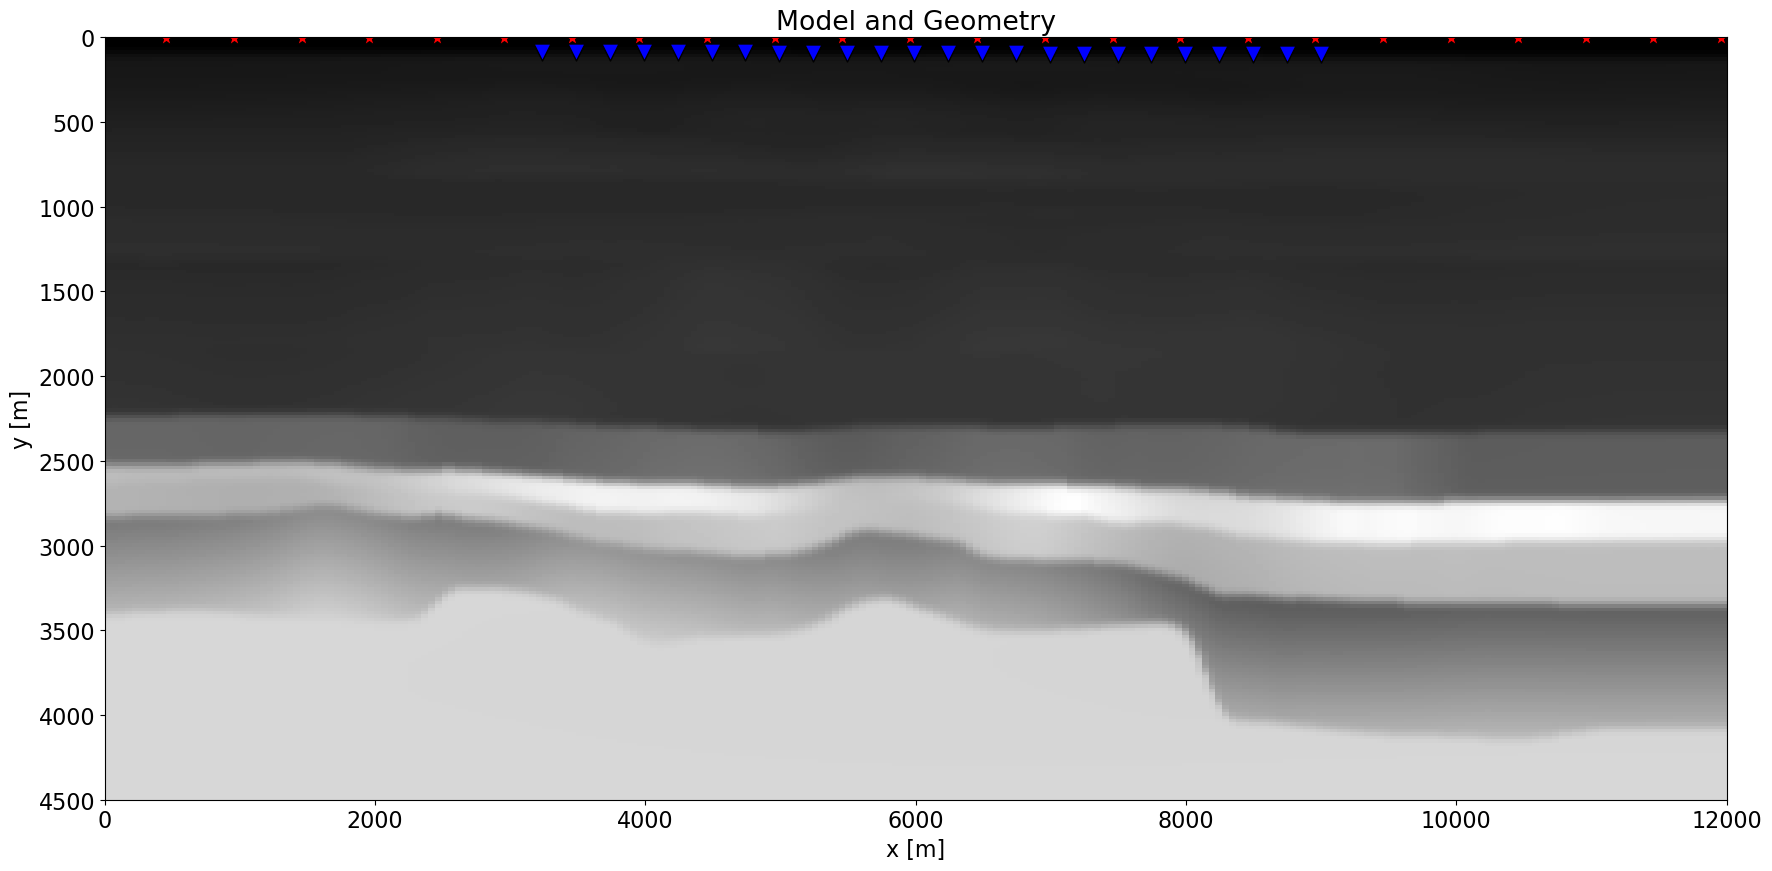

In [4]:
plt.figure(figsize=(18,9))
plt.imshow(vel, cmap='gray', extent=(x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, ::10], s[1, ::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.tight_layout()

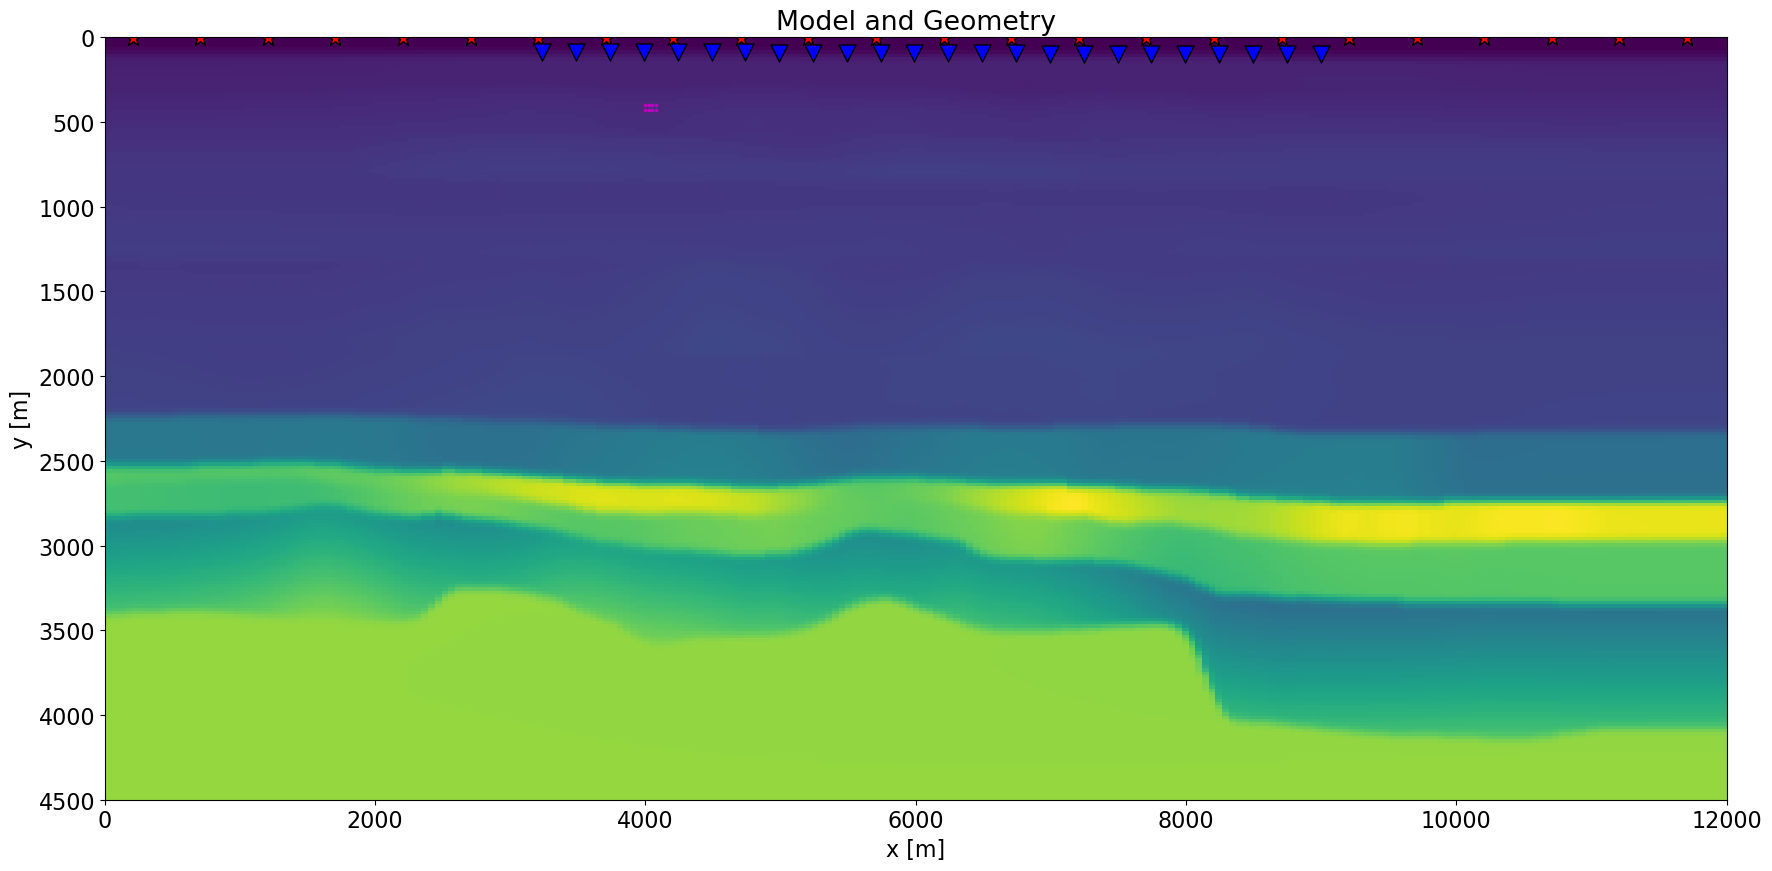

In [11]:
nvsx, nvsz = 161, 121
nvsx, nvsz = 4, 2
dvsx, dvsz = 25, 30
vsx = np.arange(nvsx)*dvsx + 4000
vsz = np.arange(nvsz)*dvsz + 400
VSX, VSZ = np.meshgrid(vsx, vsz, indexing='ij')

plt.figure(figsize=(18,9))
plt.imshow(vel, extent=(x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(VSX.ravel(), VSZ.ravel(), marker='.', s=10, c='m', edgecolors='m')
plt.axis('tight')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.tight_layout()

In [12]:
# Create interpolation function
interp_func = interp2d(np.arange(vel.shape[1]),
                       np.arange(vel.shape[0]),
                       vel,
                       kind='linear')

# Interpolate to the new dimensions
new_vel = interp_func(np.linspace(0, vel.shape[1] - 1, 2*vel.shape[1] - 1),
                      np.linspace(0, vel.shape[0] - 1, 2*vel.shape[0] - 1))
# new_vel = interp_func(np.linspace(0, vel.shape[1] - 1, 2401),
#                       np.linspace(0, vel.shape[0] - 1, 901))

In [13]:
nx = new_vel.shape[1]
nz = new_vel.shape[0]

z = np.linspace(0, 4500, nz, dtype=int)
x = np.linspace(0, 12000, nx, dtype=int)

dz = z[1] - z[0]
dx = x[1] - x[0]

In [ ]:
# para for pick (nvsx,nvsz,nr) 
nx = x.size
nz = z.size
vsx_o = int(vsx[0]/dx+1)
vsz_o = int(vsz[0]/dz)
vsx_interval = int(dvsx/dx)
vsz_interval = int(dvsz/dz)
vsx_e = int(vsx[-1]/dx+2)
vsz_e = int(vsz[-1]/dz+1)

# vel, z ,r for computing direct arrival from vs to mirror receiver
dvel_flipud = int(np.ceil(np.max(r[1])/dz))
deltvel = new_vel[0:dvel_flipud]
vel_mr = np.vstack((deltvel, new_vel))

deltz = -np.flipud(z[0:dvel_flipud])-dz
z_mr = np.hstack((deltz, z))
nz_mr = z_mr.size

zr_mr = -r[1,:]
r_mr = np.vstack((r[0,:], zr_mr))

# direct arrival from vs to mirror receiver
trav_srcs_mr, trav_recs_mr, _, _, _, _ = Kirchhoff._traveltime_table(z_mr, x, s, r_mr, vel_mr.T, mode='eikonal')

trav_s_mr   = trav_srcs_mr.reshape(nx * nz_mr, ns) 
trav_s      = trav_s_mr.reshape(nx, nz_mr, ns) 
trav_s_arr  = trav_s[:,-nz:,:]

trav_r_mr   = trav_recs_mr.reshape(nx * nz_mr, nr) 
trav_mr     = trav_r_mr.reshape(nx, nz_mr, nr) 
trav_mr_arr = trav_mr[:,-nz:,:]

# para for picking virtual sources to sources and mirror receivers
trav_mr1 = trav_mr_arr[vsx_o:vsx_e,vsz_o:vsz_e,:]
trav_mr2 = trav_mr1[::vsx_interval,::vsz_interval,:]

trav_s1 = trav_s_arr[vsx_o:vsx_e,vsz_o:vsz_e,:]
trav_s2 = trav_s1[::vsx_interval,::vsz_interval,:]

In [15]:
nprocs = 1
iss, imck, ass, amck = \
    MarchenkoImaging(vsx, vsz, r, s, dr, ds, dt, nt, vel_s, tsoff, nsmooth, wav, wav_c,
                     nfmax, igaths, nalpha, 1,dict(Vzu=Pu, Vzd=Pd), kind='rmck_upd_vv', niter=niter, 
                     nproc=nprocs,trav_s2=trav_s2, trav_mr2=trav_mr2)

ivsz =  0
ivsz =  1
Elapsed time (mins):  6.2064990679423016


In [ ]:
# display the images
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].imshow(iss, cmap='gray', vmin=-0.4*np.abs(iss).max(), vmax=0.4*np.abs(iss).max(), interpolation='sinc')
axs[0].axis('tight')
axs[1].imshow(imck, cmap='gray', vmin=-0.4*np.abs(imck).max(), vmax=0.4*np.abs(imck).max(), interpolation='sinc')
axs[1].axis('tight')
fig.tight_layout()

In [ ]:
# angle gathers
ngath = len(igaths)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
axs[0].imshow(-ass.transpose(0, 2, 1).reshape(ngath * nalpha, nvsz).T,
              cmap='gray', vmin=-5e9, vmax=5e9,
              interpolation='sinc')
axs[0].axis('tight')
axs[0].set_title('Gathers RTM')
axs[1].imshow(amck.transpose(0, 2, 1).reshape(ngath * nalpha, nvsz).T,
              cmap='gray', vmin=-5e2, vmax=5e2,
              interpolation='sinc')
axs[1].set_title('Gathers Mck')
axs[1].axis('tight')
fig.tight_layout()